In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats
from scipy.stats import describe
from statistics import mean
from statistics import stdev
import warnings # Turn off warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
import statsmodels.formula.api as smf 
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, lars_path

In [2]:
#Imports
data_df = pd.read_csv(r"data/processed-csv/bishop-proc-log-sqrt-df.csv")
data_df = data_df.drop(columns = {"Unnamed: 0"}).dropna()
data_df

,Route,ID,Avg Stars,Grade,Length,Area Latitude,Area Longitude,StarRatings,SuggestedRatings,OnToDoLists,...,Log Ticks,Log Avg Stars,Log Length,Log Grade,Log OnToDoLists,Sqrt StarRatings,Sqrt Ticks,Sqrt Avg Stars,Sqrt Length,Sqrt Grade
0,The Way Down,106277533,1.3,-1.00,10.0,37.33004,-118.57901,30,5,8,...,1.724276,0.361728,1.041393,0.000000,0.954243,5.477226,7.211103,1.140175,3.162278,0.000000
1,Choke the Chicken,116715444,2.0,-1.00,15.0,37.31826,-118.57440,1,1,0,...,0.301030,0.477121,1.204120,0.000000,0.000000,1.000000,1.000000,1.414214,3.872983,0.000000
2,Unnamed 1,1070327761,2.2,-0.25,18.0,37.32859,-118.57516,41,6,11,...,1.944483,0.505150,1.278754,0.243038,1.079181,6.403124,9.327379,1.483240,4.242641,0.866025
3,Unnamed 2,1070327802,2.8,-0.25,18.0,37.32859,-118.57516,84,20,49,...,2.227887,0.579784,1.278754,0.243038,1.698970,9.165151,12.961481,1.673320,4.242641,0.866025
4,Problem B,106322572,1.8,-0.25,12.0,37.32873,-118.57534,46,15,12,...,2.012837,0.447158,1.113943,0.243038,1.113943,6.782330,10.099505,1.341641,3.464102,0.866025
5,Hip Hop Hager,107519098,1.6,-0.25,16.0,37.33014,-118.57777,5,1,2,...,0.698970,0.414973,1.230449,0.243038,0.477121,2.236068,2.000000,1.264911,4.000000,0.866025
6,Unknown V0/V1,10644277101,1.8,-0.25,12.0,37.33022,-118.57882,8,1,7,...,1.462398,0.447158,1.113943,0.243038,0.903090,2.828427,5.291503,1.341641,3.464102,0.866025
7,Xenolith Slab,116715297,2.0,-0.25,10.0,37.31821,-118.57395,1,1,0,...,0.301030,0.477121,1.041393,0.243038,0.000000,1.000000,1.000000,1.414214,3.162278,0.866025
8,Backside Crack,108010816,2.3,0.00,20.0,37.33880,-118.57760,31,6,5,...,1.556303,0.518514,1.322219,0.301030,0.778151,5.567764,5.916080,1.516575,4.472136,1.000000
9,Burned and Bare,108880968,2.7,0.00,15.0,37.33880,-118.57760,12,3,2,...,1.000000,0.568202,1.204120,0.301030,0.477121,3.464102,3.000000,1.643168,3.872983,1.000000


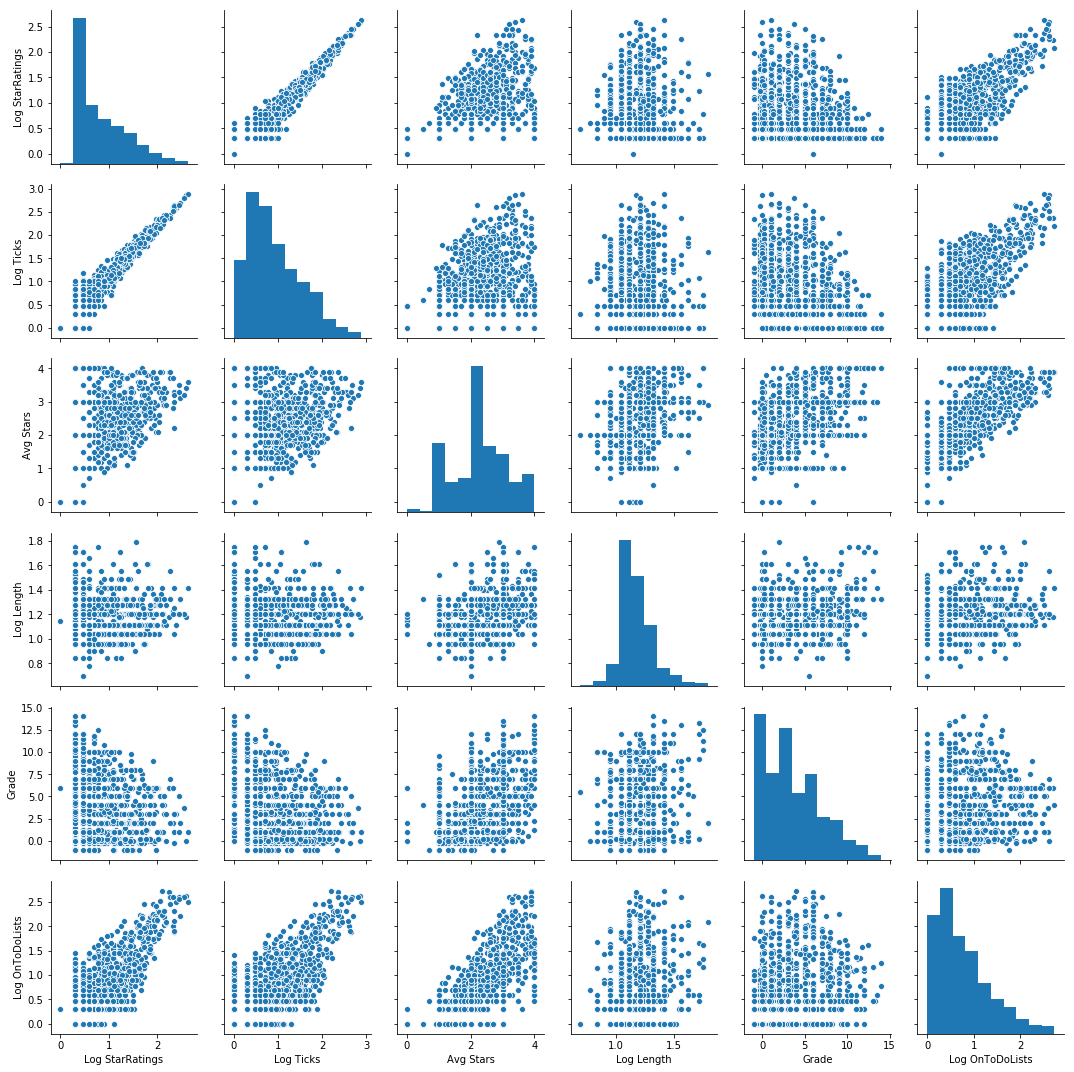

In [3]:
# Pairplot
features_target_list = ['Log StarRatings', 'Log Ticks', 'Avg Stars', 'Log Length', 'Grade', 'Log OnToDoLists']
sns.pairplot(data_df[features_target_list])
plt.savefig("figures/bishop/log-linear/log-linear-pairplot.png", transparent=True, bbox_inches="tight")

In [4]:
# Used for K-fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state = 72)
scaler = StandardScaler()

In [5]:
# Scikit Learn's LinearRegression with Log Variables

# Set aside 20% of data for final test
features_train_all_df, features_test_all_df, target_train_ser, target_test_ser = train_test_split(data_df.drop(columns = ['Log OnToDoLists']), data_df['Log OnToDoLists'], test_size=.2, random_state=42)

# Choose features, KFold requires ndarray inputs
features_list = ['Log StarRatings', 'Log Ticks', 'Avg Stars', 'Log Length', 'Grade']

features_train_chosen_df = features_train_all_df[features_list]
features_train_chosen_array = np.array(features_train_chosen_df)
features_test_chosen_df = features_test_all_df[features_list]
features_test_chosen_array = np.array(features_test_chosen_df)
target_train_array = np.array(target_train_ser)
target_test_array = np.array(target_test_ser)

# KFold Cross-Validation
r2_cv_list = [] # Collect the cross-validation results

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):
    
    # Make the split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 
    
    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    features_train_cv_scaled_array = scaler.fit_transform(features_train_cv_array)  # Scale resampled features
    features_val_cv_scaled_array = scaler.transform(features_val_cv_array)  # Scale validation features
    
    ols_model = sm.OLS(target_train_cv_array, sm.add_constant(features_train_cv_scaled_array))
    ols_results = ols_model.fit() # Fit model
    
    # Collect results on the validation set
    SSE = sum((10**target_val_cv_array-1 - 10**ols_results.predict(sm.add_constant(features_val_cv_scaled_array))-1)**2)
    SST = sum((10**target_val_cv_array-1 - 10**np.mean(target_val_cv_array)-1)**2)
    r2_cv_list.append(1-SSE/SST)

print(r2_cv_list)
print('val_r2_score: ', mean(r2_cv_list),' +/- ', stdev(r2_cv_list))

# Test
features_train_scaled_array = scaler.fit_transform(features_train_chosen_df)
features_test_scaled_array = scaler.transform(features_test_chosen_df)

# Fit model
ols_model = sm.OLS(target_train_ser, sm.add_constant(features_train_scaled_array))
ols_results = ols_model.fit()

# Save results for comparison later
OLS_array = 10**ols_results.predict(sm.add_constant(features_test_scaled_array))-1

# Collect results on the test set
SSE = sum((10**target_test_ser-1 - OLS_array)**2)
SST = sum((10**target_test_ser-1 - 10**np.mean(target_test_ser)-1)**2)

print('test_r2_score: ', 1-SSE/SST) #Get score
print(list(ols_results.params[1:]))

[0.7683539164262566, 0.8594531568618045, 0.5969286631898116, 0.6626570161372733, 0.7092653183922505]
val_r2_score:  0.7193316142014793  +/-  0.1004154565123687
test_r2_score:  0.7713159789396038
[0.28278002204863895, 0.1280748530228618, 0.24719465237837293, 0.03278768646356558, 0.04777724510731805]


In [6]:
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:        Log OnToDoLists   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     649.4
Date:                Thu, 11 Jul 2019   Prob (F-statistic):          4.61e-279
Time:                        18:01:22   Log-Likelihood:                -114.71
No. Observations:                 808   AIC:                             241.4
Df Residuals:                     802   BIC:                             269.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7440      0.010     75.548      0.0

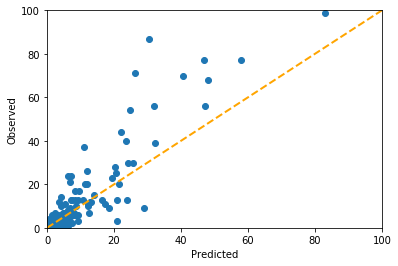

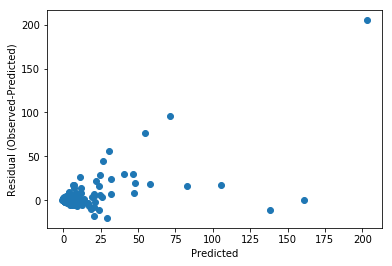

<Figure size 576x360 with 0 Axes>

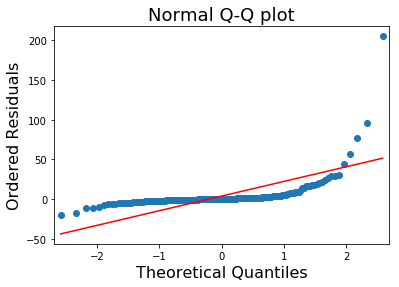

DescribeResult(nobs=202, minmax=(-19.990997961406737, 204.98011136869917), mean=3.8685518083200363, variance=342.1510033638052, skewness=7.523948583840473, kurtosis=71.6559606579703)


In [7]:
ax = plt.scatter(10**ols_results.predict(sm.add_constant(features_test_scaled_array))-1, 10**target_test_ser-1)
plt.plot([0, 500], [0, 500], c='orange', lw = 2, ls='--', label= "Equal")
plt.xlabel('Predicted')
plt.xlim(0, 100)
plt.ylabel('Observed')
plt.ylim(0, 100)
plt.savefig("figures/bishop/log-linear/predicted-vs-observed.png", transparent=True, bbox_inches="tight")
plt.show()

X = 10**ols_results.predict(sm.add_constant(features_test_scaled_array))-1
y = 10**target_test_ser-1
ax = plt.scatter(X, y-X)
plt.xlabel('Predicted')
plt.ylabel('Residual (Observed-Predicted)')
plt.savefig("figures/bishop/log-linear/predicted-vs-residual.png", transparent=True, bbox_inches="tight")
plt.show()

plt.figure(figsize=(8, 5))
res = y-X # residuals
fig = sm.qqplot(res, line='s', color = '#1f77b4')
plt.title("Normal Q-Q plot", fontsize=18)
plt.xlabel("Theoretical Quantiles", fontsize=16)
plt.ylabel("Ordered Residuals", fontsize=16)
plt.savefig("figures/bishop/log-linear/normal-qq-plot.png", transparent=True, bbox_inches="tight")
plt.show()

print(describe(y-X))

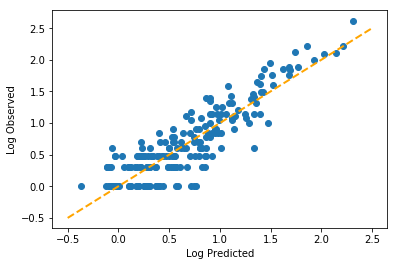

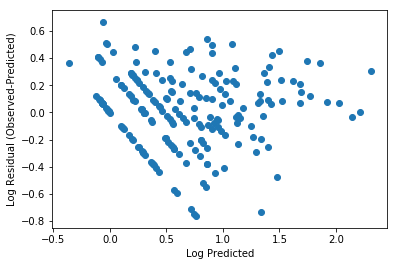

DescribeResult(nobs=202, minmax=(-0.7631913177739985, 0.6642056441133994), mean=0.021771260662402668, variance=0.07321342796972372, skewness=-0.43328366982757205, kurtosis=0.15215444127975486)


<Figure size 576x360 with 0 Axes>

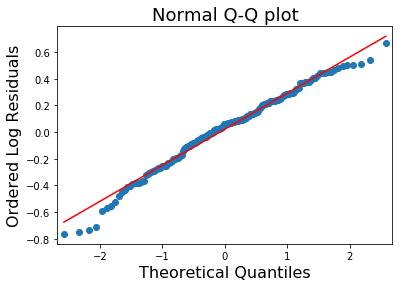

In [8]:
X = ols_results.predict(sm.add_constant(features_test_scaled_array))
y = target_test_ser
ax = plt.scatter(X, y)
plt.plot([-0.5, 2.5], [-0.5, 2.5], c='orange', lw = 2, ls='--', label= "Equal")
plt.xlabel('Log Predicted')
plt.ylabel('Log Observed')
plt.savefig("figures/bishop/log-linear/log-predicted-vs-log-observed.png", transparent=True, bbox_inches="tight")
plt.show()

X = ols_results.predict(sm.add_constant(features_test_scaled_array))
y = target_test_ser
ax = plt.scatter(X, y-X)
plt.xlabel('Log Predicted')
plt.ylabel('Log Residual (Observed-Predicted)')
plt.savefig("figures/bishop/log-linear/log-predicted-vs-residual.png", transparent=True, bbox_inches="tight")
plt.show()

print(describe(y-X))

plt.figure(figsize=(8, 5))
res = y-X # residuals
fig = sm.qqplot(res, line='s', color = '#1f77b4')
plt.title("Normal Q-Q plot", fontsize=18)
plt.xlabel("Theoretical Quantiles", fontsize=16)
plt.ylabel("Ordered Log Residuals", fontsize=16)
plt.savefig("figures/bishop/log-linear/log-qq-plot.png", transparent=True, bbox_inches="tight")

In [9]:
# Linear Regression is overestimating
X = OLS_array
y = 10**target_test_ser-1
len(list(filter(lambda x: x<=0, y-X)))

85

In [10]:
# Fit model
ols_new_model = sm.OLS(y, sm.add_constant(X))
ols_new_results = ols_new_model.fit()
ols_new_results.params

const   -1.095139
x1       1.479617
dtype: float64

In [11]:
# Statsmodels GLM Poisson

# Set aside 20% of data for final test
features_train_all_df, features_test_all_df, target_train_ser, target_test_ser = train_test_split(data_df.drop(columns = ['OnToDoLists']), data_df['OnToDoLists'], test_size=.2, random_state=42)

# Choose features, KFold requires ndarray inputs
features_list = ['Sqrt StarRatings', 'Sqrt Ticks', 'Sqrt Avg Stars', 'Sqrt Length', 'Sqrt Grade']

features_train_chosen_df = features_train_all_df[features_list]
features_train_chosen_array = np.array(features_train_chosen_df)
features_test_chosen_df = features_test_all_df[features_list]
features_test_chosen_array = np.array(features_test_chosen_df)
target_train_array = np.array(target_train_ser)
target_test_array = np.array(target_test_ser)

r2_cv_list = [] # Collect the cross-validation results

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):

    # Make split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 

    # Standard Scaler on Features
    features_train_cv_scaled_array = scaler.fit_transform(features_train_cv_array)
    features_val_cv_scaled_array = scaler.transform(features_val_cv_array)

    features_train_cv_scaled_df = pd.DataFrame(features_train_cv_scaled_array).rename(columns = {0: 'Sqrt_StarRatings', 1:'Sqrt_Ticks', 2:'Sqrt_Avg_Stars', 3: 'Sqrt_Length', 4: 'Sqrt_Grade'})
    features_train_cv_scaled_df['OnToDoLists'] = target_train_cv_array
    features_val_cv_scaled_df = pd.DataFrame(features_val_cv_scaled_array).rename(columns = {0: 'Sqrt_StarRatings', 1:'Sqrt_Ticks', 2:'Sqrt_Avg_Stars', 3: 'Sqrt_Length', 4: 'Sqrt_Grade'})
    features_val_cv_scaled_df['OnToDoLists'] = target_val_cv_array

    # Fit model
    poisson_glm_model = smf.glm("OnToDoLists ~ Sqrt_StarRatings + Sqrt_Ticks + Sqrt_Avg_Stars + Sqrt_Length + Sqrt_Grade", data=features_train_cv_scaled_df, family=sm.families.Poisson())
    poisson_glm_results = poisson_glm_model.fit()

    # Collect results
    SSE = sum((target_val_cv_array - poisson_glm_results.predict(features_val_cv_scaled_df))**2)
    SST = sum((target_val_cv_array - np.mean(target_val_cv_array))**2)
    r2_cv_score = 1-SSE/SST
    r2_cv_list.append(r2_cv_score)

r2_cv_filtered_list = list(filter(lambda x: x >= 0, r2_cv_list))
print(r2_cv_list)
print(r2_cv_filtered_list)
print('r2_cv_score: ', mean(r2_cv_filtered_list),' +/- ', stdev(r2_cv_filtered_list))

# Test
features_train_scaled_array = scaler.fit_transform(features_train_chosen_df)
features_test_scaled_array = scaler.transform(features_test_chosen_df)

features_train_scaled_df = pd.DataFrame(features_train_scaled_array).rename(columns = {0: 'Sqrt_StarRatings', 1:'Sqrt_Ticks', 2:'Sqrt_Avg_Stars', 3: 'Sqrt_Length', 4: 'Sqrt_Grade'})
features_train_scaled_df['OnToDoLists'] = target_train_array
features_test_scaled_df = pd.DataFrame(features_test_scaled_array).rename(columns = {0: 'Sqrt_StarRatings', 1:'Sqrt_Ticks', 2:'Sqrt_Avg_Stars', 3: 'Sqrt_Length', 4: 'Sqrt_Grade'})
features_test_scaled_df['OnToDoLists'] = target_test_array

poisson_glm_model = smf.glm("OnToDoLists ~ Sqrt_StarRatings + Sqrt_Ticks + Sqrt_Avg_Stars + Sqrt_Length + Sqrt_Grade", data=features_train_scaled_df, family=sm.families.Poisson())
poisson_glm_results = poisson_glm_model.fit()

# Save results for comparison
poisson_array = poisson_glm_results.predict(features_test_scaled_df)

SSE = sum((target_test_array - poisson_array)**2)
SST = sum((target_test_array - np.mean(target_test_array))**2)
r2_test_score = 1-SSE/SST

print('r2_test_score: ', r2_test_score) #Get score
print(list(poisson_glm_results.params[1:]))

[0.8657855228408797, -2.035283022058216, 0.7645869947134933, 0.9004285574116464, 0.6960494181160621]
[0.8657855228408797, 0.7645869947134933, 0.9004285574116464, 0.6960494181160621]
r2_cv_score:  0.8067126232705204  +/-  0.0936183695150618
r2_test_score:  0.8212121466062641
[1.593451872697516, -1.0234375571508436, 1.118816918444836, -0.06300388327775253, -0.03383125234546766]


In [12]:
# Why is the second fold overfitting?

val_cv_index_list = []
for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):
    val_cv_index_list.append(val_cv_index)

for i in range(5):
    print(describe(target_train_array[val_cv_index_list[i]]))

DescribeResult(nobs=162, minmax=(0, 408), mean=22.11111111111111, variance=3751.5155279503106, skewness=4.328599631645833, kurtosis=19.726683129054543)
DescribeResult(nobs=162, minmax=(0, 324), mean=16.58641975308642, variance=1882.529752319607, skewness=4.765837387359696, kurtosis=25.968169677111003)
DescribeResult(nobs=162, minmax=(0, 546), mean=24.555555555555557, variance=4560.173913043478, skewness=5.16754438486624, kurtosis=30.16983478582852)
DescribeResult(nobs=161, minmax=(0, 511), mean=20.664596273291924, variance=3881.8868012422363, skewness=5.343271750521604, kurtosis=32.60990966392185)
DescribeResult(nobs=161, minmax=(0, 412), mean=16.608695652173914, variance=1866.1146739130431, skewness=5.860591047675372, kurtosis=44.48187970726255)


In [13]:
target_train_array[val_cv_index_list[1]]

array([  3,   0,  36,   2,   1,  26,  18,   1,   2,   8,   5,   1,   3,
         2,   0,   2,   0,   6,   1,   0, 324,  17,  12,   0,   0,   8,
         1,   4,   0,  42,  25,   1,   3,   1,   6,   3,  14, 154,  27,
        25,   9,  80,   1,   9,  32,   0,  40,   0,  11,   1,  78,   7,
         2,   3, 149,   2,  13,   6,  69,   1,   4,   0,   2,   0, 292,
       182,   1,   1,   0,   0,   2,  95,   9,   3,  37,   0,   3,   1,
       136,   5,   0,   3,  31,  17,   0,   0,   6,   0,   0,   0,   3,
         3,   5,   7,   0,   8,   0,   0,   2,   9,  21,   3,   0,   7,
         7,   6,   3,   2,  20,   1,   8,   0,   2,   5,   6,   2,   7,
        15,   2,   0,   0,  34,   0,   1,   5,   1,   1,   1,   1,   0,
         6,  34,   1,   1,   4,  96,   7,   0,   1,   0,   5,  20,   2,
         0,   0,  17,   0,   2,   2,  56,   0,   5,   1,   1,   2,  35,
         6,  46,   0,   2,   3,   7])

In [14]:
print(poisson_glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            OnToDoLists   No. Observations:                  808
Model:                            GLM   Df Residuals:                      802
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4488.9
Date:                Thu, 11 Jul 2019   Deviance:                       6537.1
Time:                        18:01:24   Pearson chi2:                 7.18e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.7834      0.017    105.332      0.000       1.750       1.817
Sqrt_StarRatings     1.5935      0

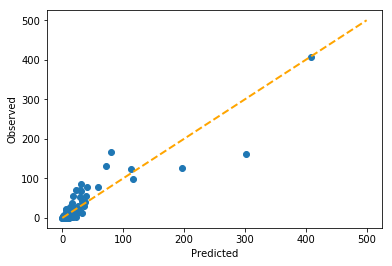

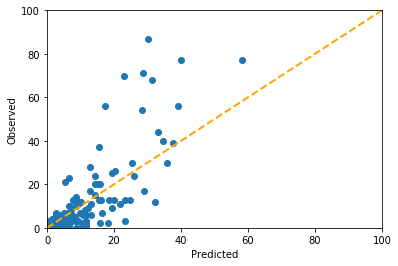

DescribeResult(nobs=202, minmax=(0, 408), mean=14.217821782178218, variance=1490.9771932417125, skewness=6.4264668760155805, kurtosis=54.82164722641344)


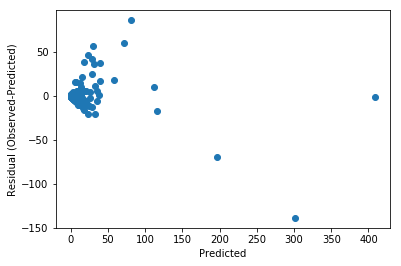

<Figure size 576x360 with 0 Axes>

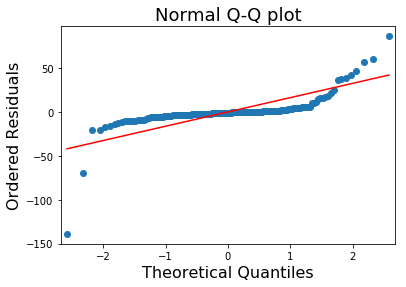

DescribeResult(nobs=202, minmax=(-139.0121923124981, 86.29287976458092), mean=0.028012929958972317, variance=266.5678232103584, skewness=-1.8777641197391048, kurtosis=31.59578563024788)


In [15]:
ax = plt.scatter(poisson_glm_results.predict(features_test_scaled_df), target_test_array)
plt.plot([0, 500], [0, 500], c='orange', lw = 2, ls='--', label= "Equal")
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.savefig("figures/bishop/poisson/predicted-vs-observed.png", transparent=True, bbox_inches="tight")
plt.show()

ax = plt.scatter(poisson_glm_results.predict(features_test_scaled_df), target_test_array)
plt.plot([0, 500], [0, 500], c='orange', lw = 2, ls='--', label= "Equal")
plt.xlabel('Predicted')
plt.xlim(0, 100)
plt.ylabel('Observed')
plt.ylim(0, 100)
plt.savefig("figures/bishop/poisson/predicted-vs-observed-zoomed-in.png", transparent=True, bbox_inches="tight")
plt.show()

print(describe(target_test_array))

X = poisson_glm_results.predict(features_test_scaled_df)
y = target_test_array
ax = plt.scatter(X, y-X)
plt.xlabel('Predicted')
plt.ylabel('Residual (Observed-Predicted)')
plt.savefig("figures/bishop/poisson/predicted-vs-residual.png", transparent=True, bbox_inches="tight")
plt.show()

plt.figure(figsize=(8, 5))
res = y-X # residuals
fig = sm.qqplot(res, line='s', color = '#1f77b4')
plt.title("Normal Q-Q plot", fontsize=18)
plt.xlabel("Theoretical Quantiles", fontsize=16)
plt.ylabel("Ordered Residuals", fontsize=16)
plt.savefig("figures/bishop/poisson/normal-qq-plot.png", transparent=True, bbox_inches="tight")
plt.show()

print(describe(y-X))

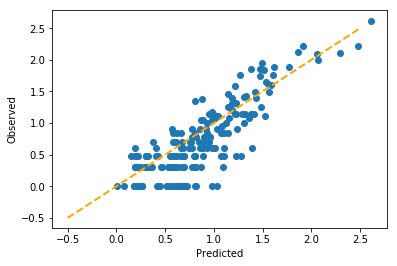

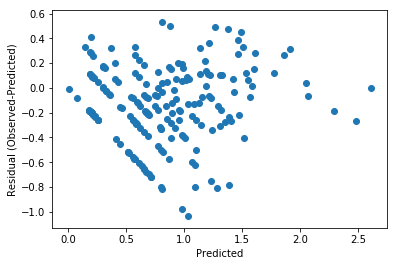

DescribeResult(nobs=202, minmax=(-1.0359326757707163, 0.5320164588599453), mean=-0.1314304149846742, variance=0.09156017699864616, skewness=-0.38136113404102273, kurtosis=0.057796499376001176)


<Figure size 576x360 with 0 Axes>

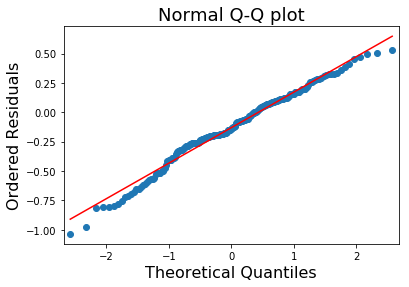

In [16]:
X = np.log(np.array(poisson_glm_results.predict(features_test_scaled_df)+1))/math.log(10)
y = np.log(target_test_array+1)/math.log(10)
ax = plt.scatter(X, y)
plt.plot([-0.5, 2.5], [-0.5, 2.5], c='orange', lw = 2, ls='--', label= "Equal")
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.savefig("figures/bishop/poisson/log-predicted-vs-log-observed.png", transparent=True, bbox_inches="tight")
plt.show()

X = np.log(np.array(poisson_glm_results.predict(features_test_scaled_df)+1))/math.log(10)
y = np.log(target_test_array+1)/math.log(10)
ax = plt.scatter(X, y-X)
plt.xlabel('Predicted')
plt.ylabel('Residual (Observed-Predicted)')
plt.savefig("figures/bishop/poisson/log-predicted-vs-residual.png", transparent=True, bbox_inches="tight")
plt.show()

print(describe(y-X))

plt.figure(figsize=(8, 5))
res = y-X # residuals
fig = sm.qqplot(res, line='s', color = '#1f77b4')
plt.title("Normal Q-Q plot", fontsize=18)
plt.xlabel("Theoretical Quantiles", fontsize=16)
plt.ylabel("Ordered Residuals", fontsize=16)
plt.savefig("figures/bishop/poisson/log-qq-plot.png", transparent=True, bbox_inches="tight")

In [17]:
# Poisson is underestimating
X = poisson_array
y = target_test_array
len(list(filter(lambda x: x<=0, y-X)))

131

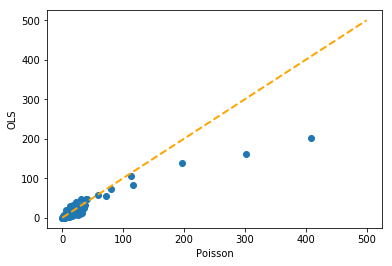

In [18]:
# Compare models
ax = plt.scatter(poisson_array, OLS_array)
plt.plot([0, 500], [0, 500], c='orange', lw = 2, ls='--', label= "Equal")
plt.xlabel('Poisson')
plt.ylabel('OLS')
plt.savefig("figures/bishop/comparison/poisson-vs-ols.png", transparent=True, bbox_inches="tight")
plt.show()